## Migrating from Spark to BigQuery via Dataproc -- Part 1

* [Part 1](01_spark.ipynb): The original Spark code, now running on Dataproc (lift-and-shift).
* [Part 2](02_gcs.ipynb): Replace HDFS by Google Cloud Storage. This enables job-specific-clusters. (cloud-native)
* [Part 3](03_automate.ipynb): Automate everything, so that we can run in a job-specific cluster. (cloud-optimized)
* [Part 4](04_bigquery.ipynb): Load CSV into BigQuery, use BigQuery. (modernize)
* [Part 5](05_functions.ipynb): Using Cloud Functions, launch analysis every time there is a new file in the bucket. (serverless)


### Copy data to HDFS

The Spark code in this notebook is based loosely on the [code](https://github.com/dipanjanS/data_science_for_all/blob/master/tds_spark_sql_intro/Working%20with%20SQL%20at%20Scale%20-%20Spark%20SQL%20Tutorial.ipynb) accompanying [this post](https://opensource.com/article/19/3/apache-spark-and-dataframes-tutorial) by Dipanjan Sarkar. I am using it to illustrate migrating a Spark analytics workload to BigQuery via Dataproc.

The data itself comes from the 1999 KDD competition. Let's grab 10% of the data to use as an illustration.

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download vijayuv/onlineretail
! unzip onlineretail.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=92cf4cefd4572bb03d317ca3e740f5cc0740bb9aab864e54c78a5ad1a38ec656
  Stored in directory: /root/.cache/pip/wheels/03/f3/c7/fc5a63bb33d22177609b06c5b4c714b5eb3f1b195ce9dc5e47
Successfully built kaggle
  0%|                                               | 0.00/7.20M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 7.20M/7.20M [00:00<00:00, 118MB/s]
Archive:  onlineretail.zip
  inflating: OnlineRetail.csv        


In [2]:
!hadoop fs -put OnlineRetail* /

In [3]:
!hadoop fs -ls /

Found 4 items
-rw-r--r--   2 root hadoop   45580638 2022-12-05 14:12 /OnlineRetail.csv
drwxrwxrwt   - hdfs hadoop          0 2022-12-05 14:06 /tmp
drwxrwxrwt   - hdfs hadoop          0 2022-12-05 14:06 /user
drwxrwxrwt   - hdfs hadoop          0 2022-12-05 14:06 /var


### Reading in data

The data are CSV files. In Spark, these can be read using textFile and splitting rows on commas.

In [4]:
from pyspark.sql import SparkSession, SQLContext, Row

spark = SparkSession.builder.appName("kdd").getOrCreate()
sc = spark.sparkContext
header=spark.sparkContext.textFile("hdfs:///OnlineRetail.csv").first()
data_file = "hdfs:///OnlineRetail.csv"
raw_rdd = sc.textFile(data_file).filter(lambda l :not str(l).startswith(header)).cache()
raw_rdd.take(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/05 14:13:05 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/12/05 14:13:05 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/12/05 14:13:05 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/12/05 14:13:05 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/12/05 14:13:15 WARN org.apache.hadoop.util.concurrent.ExecutorHelper: Thread (Thread[GetFileInfo #0,5,main]) interrupted: 
java.lang.InterruptedException
	at com.google.common.util.concurrent.AbstractFuture.get(AbstractFuture.java:510)
	at com.google.common.util.concurrent.FluentFuture$TrustedFuture.get(FluentFuture.java:88)
	at org.apache.hadoop.util.concurrent.ExecutorHelper.logThrowableFromAfterExecute(ExecutorHelper.java:48)
	at org.apache.hadoop.util.concurrent.HadoopThreadPoolExecutor.afterExecute(HadoopThreadPoolExecut

['536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom',
 '536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom',
 '536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom',
 '536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom',
 '536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom']

In [8]:
csv_rdd = raw_rdd.map(lambda row: row.split(","))
parsed_rdd = csv_rdd.map(lambda r: Row(
    invoiceNo=r[0], 
    stockcode=r[1],
    description=r[2],
    quantity=r[3],
    invoicedate=r[4],
    unitprice=r[5],
    customerid=r[6],
    country=r[7]
    )
)
parsed_rdd.take(5)

[Row(invoiceNo='536365', stockcode='85123A', description='WHITE HANGING HEART T-LIGHT HOLDER', quantity='6', invoicedate='12/1/2010 8:26', unitprice='2.55', customerid='17850', country='United Kingdom'),
 Row(invoiceNo='536365', stockcode='71053', description='WHITE METAL LANTERN', quantity='6', invoicedate='12/1/2010 8:26', unitprice='3.39', customerid='17850', country='United Kingdom'),
 Row(invoiceNo='536365', stockcode='84406B', description='CREAM CUPID HEARTS COAT HANGER', quantity='8', invoicedate='12/1/2010 8:26', unitprice='2.75', customerid='17850', country='United Kingdom'),
 Row(invoiceNo='536365', stockcode='84029G', description='KNITTED UNION FLAG HOT WATER BOTTLE', quantity='6', invoicedate='12/1/2010 8:26', unitprice='3.39', customerid='17850', country='United Kingdom'),
 Row(invoiceNo='536365', stockcode='84029E', description='RED WOOLLY HOTTIE WHITE HEART.', quantity='6', invoicedate='12/1/2010 8:26', unitprice='3.39', customerid='17850', country='United Kingdom')]

### Spark analysis

One way to analyze data in Spark is to call methods on a dataframe.

In [13]:
import pyspark.sql.functions as F

sqlContext = SQLContext(sc)
df = sqlContext.createDataFrame(parsed_rdd)
df_clean = df.withColumn("customerid", df.customerid.cast('int'))
df_clean = df.withColumn("quantity", df.customerid.cast('int'))
df_clean = df.withColumn("unitprice", df.customerid.cast('float'))
df_clean = df_clean.filter(F.col('customerid').isNotNull())
df_clean = df_clean.filter(F.col('quantity').isNotNull())
df_clean = df_clean.filter(F.col('unitprice').isNotNull())
df_clean.show()

df_user = df_clean.groupBy('customerid').count().orderBy('count', ascending=False)
df_user.show()
df_user.printSchema()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|invoiceNo|stockcode|         description|quantity|   invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|  17850.0|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|  17850

+----------+-----+
|customerid|count|
+----------+-----+
|     17841| 7931|
|     14911| 5863|
|     14096| 5044|
|     12748| 4609|
|     14606| 2721|
|     15311| 2467|
|     14646| 2071|
|     13089| 1832|
|     13263| 1641|
|     14298| 1604|
|     15039| 1505|
|     14156| 1412|
|     18118| 1270|
|     14159| 1207|
|     14796| 1147|
|     15005| 1140|
|     16033| 1134|
|     14056| 1126|
|     14769| 1087|
|     17511| 1073|
+----------+-----+
only showing top 20 rows

root
 |-- customerid: string (nullable = true)
 |-- count: long (nullable = false)



Another way is to use Spark SQL

In [20]:
df_clean.registerTempTable("purchases")
attack_stats = sqlContext.sql("""
                           SELECT 
                             customerid,
                             SUM(unitprice * quantity) as totalspent 
                           FROM purchases
                           GROUP BY customerid
                           ORDER BY totalspent DESC
                           """)
attack_stats.show()

+----------+-------------+
|customerid|   totalspent|
+----------+-------------+
|     14646|2.862165258E9|
|     17450| 1.20455605E9|
|     18102|1.160736444E9|
|     14911|1.141750181E9|
|     17511|1.098359964E9|
|     12415|  9.3512263E8|
|     13694| 8.42715066E8|
|     14298| 8.14228206E8|
|     14156| 8.01059728E8|
|     16684| 7.93858088E8|
|     15311| 5.76642882E8|
|     17404|  5.5797224E8|
|     16422| 5.35225824E8|
|     16333| 5.25661272E8|
|     16029| 5.15300292E8|
|     17949| 4.94871879E8|
|     17381| 4.45753126E8|
|     15769|  4.3617054E8|
|     15061| 4.28244474E8|
|     17841| 4.04598198E8|
+----------+-------------+
only showing top 20 rows



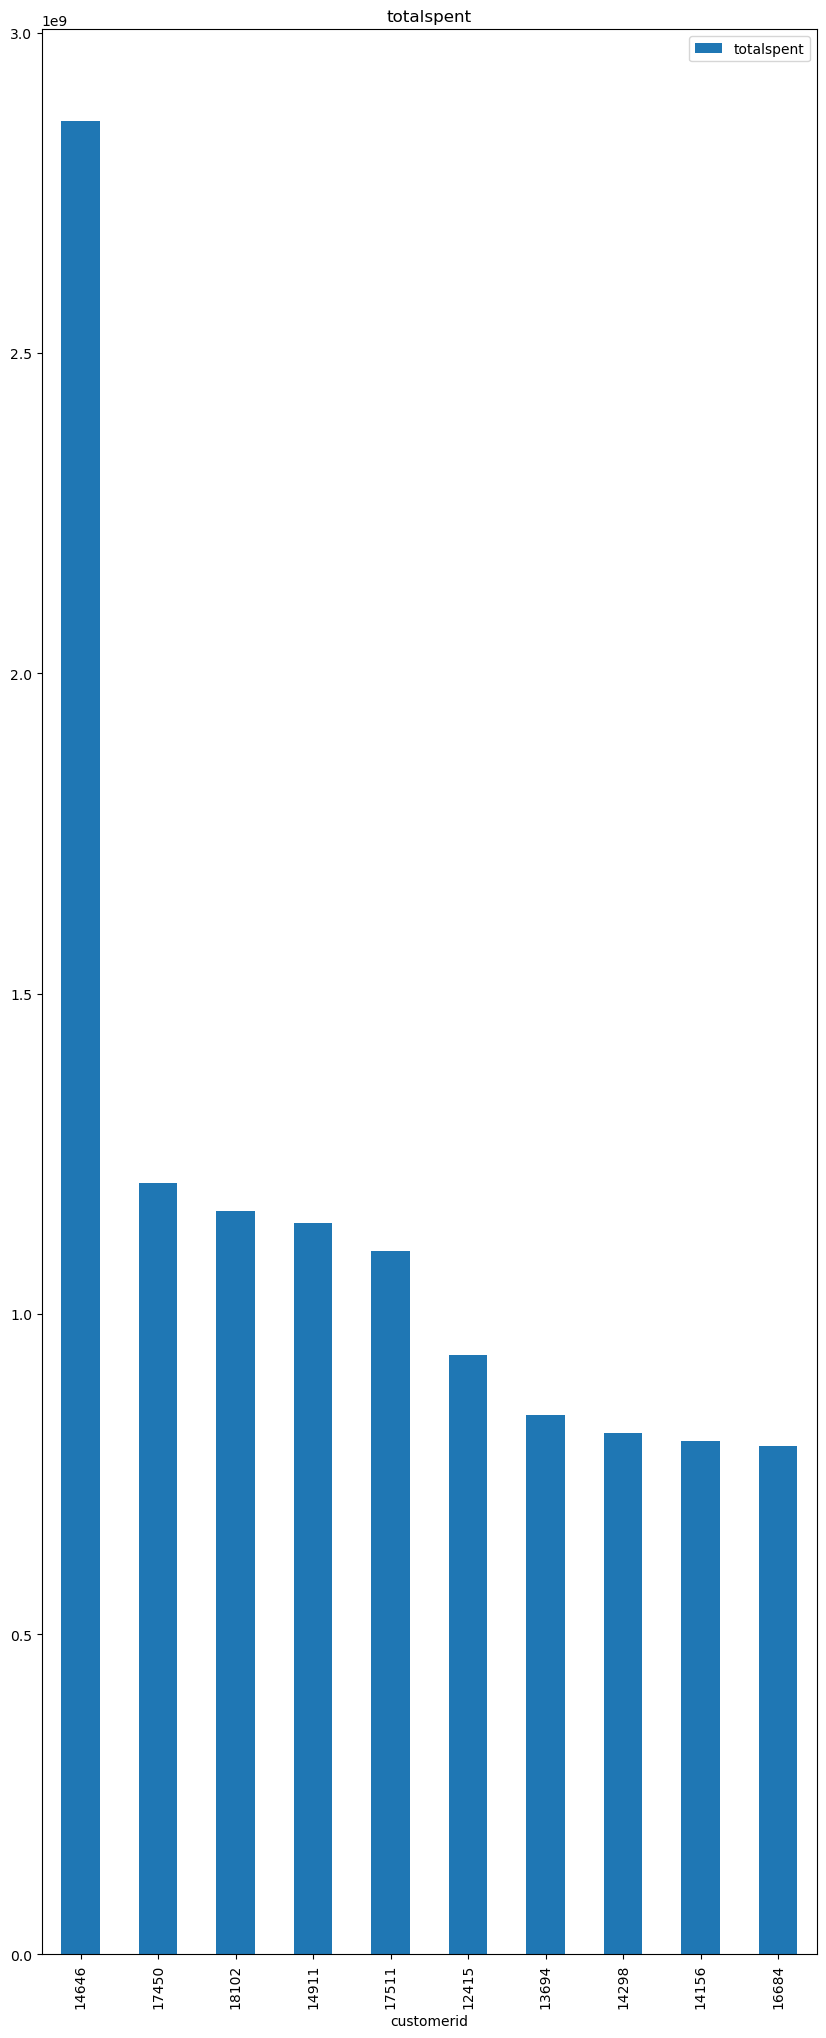

In [22]:
%matplotlib inline
df_plot = attack_stats.limit(10)
ax = df_plot.toPandas().plot.bar(x='customerid', subplots=True, figsize=(10,25))

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.